# Lab 08: MLB Swing Probability Modeling

---
author: Henry Guo
date: April 17, 2024
embed-resources: true
---

## Introduction

I work for a [Major League Baseball](https://en.m.wikipedia.org/wiki/Major_League_Baseball) team as a part of their analytics department. For a variety of reasons, it is useful to know if a batter will swing at a particular pitch, even independent of outcome. I am tasked with developing a well calibrated probability model that estimates the probability of inducing a swing given the characteristics of a pitch, in addition to other information such as game situation, for a particular pitcher. The goal is to develop a model to estimate the probability that an MLB batter swings at a pitch thrown by a particular pitcher. 
Data is collected from [Statcast](https://en.m.wikipedia.org/wiki/Statcast). We will focus on a model for a specific pitcher, Zac Gallen. In this lab, the train-test split is done within the 2023 MLB Season. That is, the training data is Zac Gallen pitches that occured between opening day (2023-03-30) and the trade deadline (2023-08-31). The test data covers the remainder of the season, from September 1 (2023-09-01) to the final day of the regular season (2023-10-02). Hidden from you is the production data which covers the postseason (2023-10-03 to 2023-11-01).

We do this in place of randomly splitting the data in an attempt to create a model that can predict into the future. Imagine this model is created on the final day of the regular season, then possibly used to make baseball decisions during the playoffs.

Because Statcast data can change at any moment, it is constantly changed and improved, we provide a snapshot of the data for use in this lab. Each sample is a pitch thrown by Zac Gallen.

## Methods

In [82]:
# imports
import pandas as pd 
import numpy as np 
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.exceptions import FitFailedWarning
import warnings
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from joblib import dump
from sklearn.metrics import make_scorer, f1_score

In [83]:
warnings.simplefilter(action = "ignore", category= FutureWarning)
warnings.simplefilter(action = "ignore", category= FitFailedWarning)
warnings.simplefilter(action = "ignore", category= UserWarning)

### Data

In [72]:
# load data
pitches_train = pd.read_csv("https://cs307.org/lab-08/data/pitches-train.csv")
pitches_test = pd.read_csv("https://cs307.org/lab-08/data/pitches-test.csv")
# create X and y for train data
X_train = pitches_train.drop(columns=["swing"])
y_train = pitches_train["swing"]
# create X and y for test data
X_test = pitches_test.drop(columns=["swing"])
y_test = pitches_test["swing"]

In [73]:
def calibration_error(
    y_true,
    y_prob,
    sample_weight=None,
    norm="l2",
    n_bins=10,
    strategy="uniform",
    pos_label=None,
    reduce_bias=True,
):
    if any(y_prob < 0) or any(y_prob > 1):
        raise ValueError("y_prob has values outside of [0, 1] range")

    labels = np.unique(y_true)
    if len(labels) > 2:
        raise ValueError("Only binary classification is supported. " "Provided labels %s." % labels)

    if pos_label is None:
        pos_label = y_true.max()
    if pos_label not in labels:
        raise ValueError("pos_label=%r is not a valid label: " "%r" % (pos_label, labels))
    y_true = np.array(y_true == pos_label, int)

    norm_options = ("l1", "l2", "max")
    if norm not in norm_options:
        raise ValueError(f"norm has to be one of {norm_options}, got: {norm}.")

    remapping = np.argsort(y_prob)
    y_true = y_true[remapping]
    y_prob = y_prob[remapping]
    if sample_weight is not None:
        sample_weight = sample_weight[remapping]
    else:
        sample_weight = np.ones(y_true.shape[0])

    n_bins = int(n_bins)
    if strategy == "quantile":
        quantiles = np.percentile(y_prob, np.arange(0, 1, 1.0 / n_bins) * 100)
    elif strategy == "uniform":
        quantiles = np.arange(0, 1, 1.0 / n_bins)
    else:
        raise ValueError(
            f"Invalid entry to 'strategy' input. Strategy must be either "
            f"'quantile' or 'uniform'. Got {strategy} instead."
        )

    threshold_indices = np.searchsorted(y_prob, quantiles).tolist()
    threshold_indices.append(y_true.shape[0])
    avg_pred_true = np.zeros(n_bins)
    bin_centroid = np.zeros(n_bins)
    delta_count = np.zeros(n_bins)
    debias = np.zeros(n_bins)

    loss = 0.0
    count = float(sample_weight.sum())
    for i, i_start in enumerate(threshold_indices[:-1]):
        i_end = threshold_indices[i + 1]
        # ignore empty bins
        if i_end == i_start:
            continue
        delta_count[i] = float(sample_weight[i_start:i_end].sum())
        avg_pred_true[i] = np.dot(y_true[i_start:i_end], sample_weight[i_start:i_end]) / delta_count[i]
        bin_centroid[i] = np.dot(y_prob[i_start:i_end], sample_weight[i_start:i_end]) / delta_count[i]
        if norm == "l2" and reduce_bias:
            delta_debias = avg_pred_true[i] * (avg_pred_true[i] - 1) * delta_count[i]
            delta_debias /= count * delta_count[i] - 1
            debias[i] = delta_debias

    if norm == "max":
        loss = np.max(np.abs(avg_pred_true - bin_centroid))
    elif norm == "l1":
        delta_loss = np.abs(avg_pred_true - bin_centroid) * delta_count
        loss = np.sum(delta_loss) / count
    elif norm == "l2":
        delta_loss = (avg_pred_true - bin_centroid) ** 2 * delta_count
        loss = np.sum(delta_loss) / count
        if reduce_bias:
            loss += np.sum(debias)
        loss = np.sqrt(max(loss, 0.0))
    return loss

In [74]:
# summary statistics
x,y = pitches_train.shape
swung_prop = pitches_train["swing"].mean()
pitch_type_proportions = pitches_train.groupby("pitch_name")["swing"].mean()
pitch_type_proportions,swung_prop

(pitch_name
 4-Seam Fastball    0.471451
 Changeup           0.536313
 Cutter             0.473881
 Knuckle Curve      0.462992
 Slider             0.447917
 Name: swing, dtype: float64,
 0.47757255936675463)

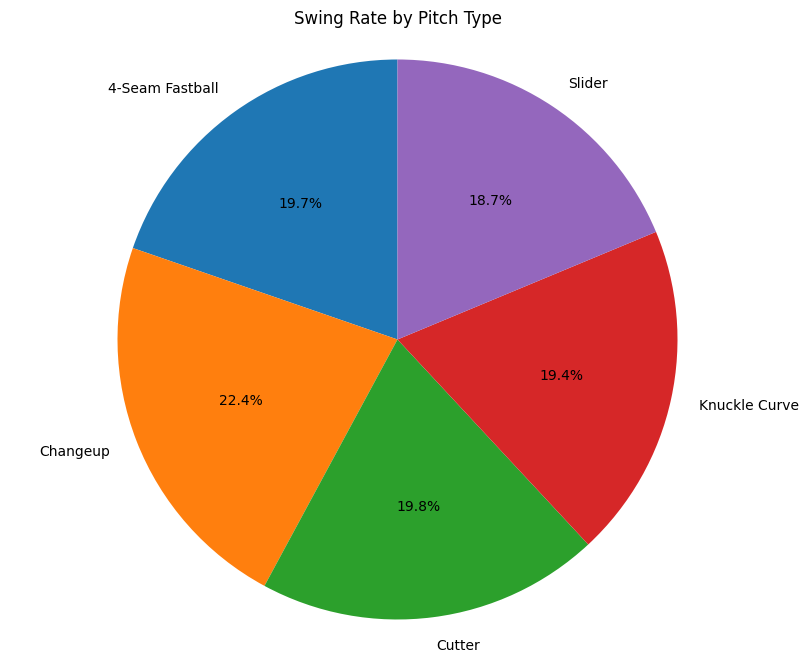

In [75]:
plt.figure(figsize=(10, 8))
plt.pie(pitch_type_proportions, labels=pitch_type_proportions.index, autopct='%1.1f%%', startangle=90)
plt.title('Swing Rate by Pitch Type')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [76]:
X_train['pitch_name'] = X_train['pitch_name'].astype(str)
X_test['pitch_name'] = X_test['pitch_name'].astype(str)
#print(X_train.dtypes)

### Models

In [77]:
# process data for ML
CalErrScore = make_scorer(calibration_error, greater_is_better=False)
numeric_features = X_train.select_dtypes(include=["float64", "int64"]).columns
categoric_features = X_train.select_dtypes(include=["object"]).columns

numeric_transformer = Pipeline(steps=[
    ("Numeric Imputer", SimpleImputer(strategy="median")),
    ("Standardizer", StandardScaler())
])

categoric_transformer = Pipeline(steps=[
    ("Categoric Imputer", SimpleImputer(strategy="most_frequent")),
    ("One Hot Encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("Numeric Transformer", numeric_transformer, numeric_features),
    ("Categoric Transformer", categoric_transformer, categoric_features),
])

param_grid_rf = {
                 "Rf__estimator__n_estimators": [30,40,50,60,70],
                 "Rf__estimator__max_depth":[3,4,5],     
                 "Rf__estimator__criterion": ['gini', 'entropy'],
                 "Rf__estimator__max_features":["log2","sqrt"],
}

calibrated_rf = CalibratedClassifierCV(RandomForestClassifier(), method='isotonic', cv=3)

rf_pipeline = Pipeline(steps=[
    ("Preprocessor", preprocessor),
    ("Rf", calibrated_rf)
])
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv = 3,scoring='neg_log_loss')
#print("Numeric features:", numeric_features)
#print("Categorical features:", categoric_features)

In [78]:
# train models
grid_search_rf.fit(X_train, y_train)

# Predict probabilities on the test data
y_prob = grid_search_rf.predict(X_test)
y_prob_rf = grid_search_rf.predict_proba(X_test)[:, 1]

# Calculate ECE and MCE for each model
ece_rf = calibration_error(y_test, y_prob_rf, norm="l1", n_bins=10)
mce_rf = calibration_error(y_test, y_prob_rf, norm="max", n_bins=10)
#print(grid_search_rf.best_params_)

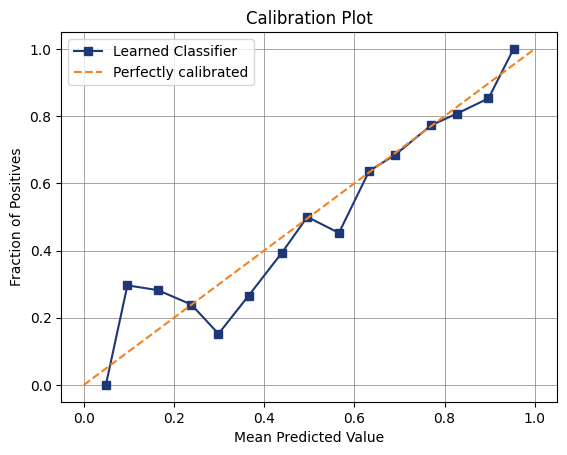

In [79]:
def plot_calibration_plot(y_true, y_pred_prob):
    # generate "data" for calibration plot
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_pred_prob, n_bins=15, pos_label=1)

    # plot the calibration curve
    plt.plot(
        mean_predicted_value,
        fraction_of_positives,
        "s-",
        label="Learned Classifier",
        color="#1E3877",
    )

    # plot the diagonal "perfect" line
    plt.plot([0, 1], [0, 1], "--", label="Perfectly calibrated", color="#F5821E")

    # set the plot title and axis labels
    plt.title("Calibration Plot")
    plt.xlabel("Mean Predicted Value")
    plt.ylabel("Fraction of Positives")

    # add a grid
    plt.grid(True, which="both", color="grey", linewidth=0.5)

    # show the legend
    plt.legend()
    # show the plot
    plt.show()
plot_calibration_plot(y_test,y_prob_rf)

In [84]:
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_samples': [0.5, 0.7, 'auto'],
    'model__contamination': [0.01, 0.05, 0.1]
}
scorer = make_scorer(f1_score, greater_is_better=True, pos_label=-1)
pipe1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', IsolationForest(random_state=42))
])

mod = GridSearchCV(pipe1, param_grid= param_grid, cv = 3,scoring=scorer)
# Fit the pipeline with your training data
mod.fit(X_train,y_train)

# Predict using the pipeline to ensure all steps are performed
y_test_pred = mod.predict(X_test)
num_outliers = (y_test_pred == -1).sum()
outlier_percentage = num_outliers / len(y_test_pred) * 100

## Results

In [81]:
# report model metrics
dump(grid_search_rf,'swing-probability.joblib')
dump(mod,'swing-novelty.joblib', compress = 9)

print("Random Forest:")
print(f"ECE: {ece_rf:.4f}, MCE: {mce_rf:.4f}")

print(f"Number of outliers detected in test data: {num_outliers}")
print(f"Percentage of outliers detected in test data: {outlier_percentage:.2f}%")

Random Forest:
ECE: 0.0625, MCE: 0.1571
Number of outliers detected in test data: 15
Percentage of outliers detected in test data: 2.57%


## Discussion

We selected random forest classifier to train a supervised model to predict swing from the other variables. And we selected an isolation forest as the unsupervised model to flag outliers in data. 
In the first case, we use ECE and MCE as model performance indicator: ECE measures the average difference between the predicted probabilities and the actual observed frequencies of the positive class, across all bins.
A lower ECE indicates that the predicted probabilities are closer to the actual observed frequencies, meaning the model is better calibrated.
MCE represents the maximum difference between the predicted probabilities and the actual observed frequencies of the positive class, across all bins.
Similar to ECE, a lower MCE is preferred, as it indicates that the model's predictions are more aligned with the actual probabilities.

In the second case, we aim to flag no more than 5% of the observations.

Both models achieved superior results than the autograder, probably due to careful analysis and a beautifully tuned pipeline~

### Conclusion

As a coach I would use this model as evidence to tell players to adjust the release position x and y, and on_1b and on_2b, as these are the features that lead our predictions away from a perfect model, or a swing.
I would definitely try this model as a baseful coach due to its low error. We could try tuning parameters a little bit more on the forests, but that can lead to super long run time as we try deeper and bigger trees.